In [1]:
#Import libraries
import re
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, scale
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection.univariate_selection import chi2, SelectKBest
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, \
                            precision_recall_fscore_support, precision_recall_curve, roc_curve, auc

from keras import backend as K
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, Callback
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from string import punctuation
import gensim
from gensim.models.word2vec import Word2Vec 

from nltk.tokenize import TweetTokenizer # a tweet tokenizer from nltk.
tokenizer = TweetTokenizer()

Using TensorFlow backend.


## Preprocessing

In [2]:
# Import dataset and keep texts and their labels
df = pd.read_csv("./training.1600000.processed.noemoticon.csv",encoding="ISO-8859-1",names = ["label", "ids", "date", "flag","user", "text"])
df = df.drop(["ids", "date", "flag", "user"], axis = 1)
df.loc[df.label == 4, 'label'] = 1
df = shuffle(df)
df.head(5)

,label,text
138937,0,"@Catalystmaker Thanks, my friend pointed me to..."
838483,1,@clementinecutie why post that???? Get well ...
256585,0,stupid twitter wont do what i tell it to
1360212,1,@samboothey oooah cool is beyonce like a ma...
877929,1,"Oooh!! Three's Company on tv, this night could..."


In [3]:
df.label.value_counts()

1    800000
0    800000
Name: label, dtype: int64

In [4]:
# Preprocess tweets, part of code for this function is adapted from Kaggle Kernal: 
# https://www.kaggle.com/mistryjimit26/twitter-sentiment-analysis-basic
def preprocess_tweet(tweet):
    #convert the tweet to lower case
    tweet.lower()
    #convert all urls to sting "URL"
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
    #convert all @username to "AT_USER"
    tweet = re.sub('@[^\s]+','AT_USER', tweet)
    #correct all multiple white spaces to a single white space
    tweet = re.sub('[\s]+', ' ', tweet)
    #convert "#topic" to just "topic"
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    return tweet

In [5]:
tweets = np.array(df['text'].apply(preprocess_tweet))
sentiment = np.array(df.label)

#split the data into training and tesing set
X_train, X_test, y_train, y_test = train_test_split(tweets, sentiment, test_size = 0.20, random_state= 1) 

#example tweets after preprocessing
for i in range(5):
    print(X_train[i])

AT_USER Mine is being stupid. 
AT_USER Hi Mickey! Haven't been as much as I would like Doing well. Always nice to see you!!
Pixar rules! They did it &quot;UP&quot; again big time! I almost cried at parts... 
I am goofing around when I should be working 
Congratulations AT_USER winner of today's Twitterhood Quiz! Am I right in thinking you've won before? 


In [6]:
# Use TF-IDF vectorizer to transfer cleaned tweets to feature vectors
tfv=TfidfVectorizer(min_df=0, max_features=None, strip_accents='unicode',lowercase =True,
                    analyzer='word', ngram_range=(1,2), use_idf=True,smooth_idf=True, 
                    sublinear_tf=True, stop_words = "english") 
X_train_vec = tfv.fit_transform(X_train)
X_test_vec = tfv.transform(X_test)

In [7]:
# Tokenize and lemmatize tweets
lemmatizer = WordNetLemmatizer() 
tokenized_tweets =[]

for tweet in tweets:  
    tokens = tokenizer.tokenize(tweet)
    x = [lemmatizer.lemmatize(token) for token in tokens] 
    z = " ".join(x)
    tokenized_tweets.append(z)
    
X_train_TL, X_test_TL, y_train_TL, y_test_TL = train_test_split(tokenized_tweets, sentiment, test_size = 0.20, random_state=123)

In [8]:
# Use TF-IDF vectorizer to transform tokenized and Lemmatized tweets to feature vectors
tfv=TfidfVectorizer(min_df=0, max_features=None, strip_accents='unicode',lowercase =True,
                    analyzer='word', ngram_range=(1,2), use_idf=True,smooth_idf=True, 
                    sublinear_tf=True, stop_words = "english")
X_trainTL_vec = tfv.fit_transform(X_train_TL)
X_testTL_vec = tfv.transform(X_test_TL)

## Naive Bayes

In [9]:
# Apply Naive Bayes model on tokenized and Lemmatized tweets
nb = MultinomialNB(alpha = 10)
nb.fit(X_trainTL_vec, y_train_TL)
y_pred_nb = nb.predict(X_testTL_vec)

acc_nb = cross_val_score(estimator=nb, X=X_trainTL_vec, y=y_train_TL, cv=10).mean()
precision, recall, f1, _ = precision_recall_fscore_support(y_test_TL, y_pred_nb, average='weighted')
print("The accuracy of Naive Bayes after tokenization and lemmatization is:", acc_nb)
print("The weighted F1 score of Naive Bayes after tokenization and lemmatization is:", f1)

('The accuracy of Naive Bayes after tokenization and lemmatization is:', 0.7758328131781191)
('The weighted F1 score of Naive Bayes after tokenization and lemmatization is:', 0.7764740611928878)


In [10]:
# Apply Naive Bayes model on preprocssed tweets without tokenization and lemmatization,
# Model seems performs a little bit better on tweets without tokenization and lemmatization.
nb = MultinomialNB(alpha = 10)
nb.fit(X_train_vec, y_train)
y_pred_nb = nb.predict(X_test_vec)

print("The accuracy of Naive Bayes is:", cross_val_score(estimator=nb, X=X_train_vec, y=y_train, cv=10).mean())
print("The weighted F1 score of Naive Bayes is:", f1_score(y_test, y_pred_nb,average='weighted'))

('The accuracy of Naive Bayes is:', 0.7761257807712064)
('The weighted F1 score of Naive Bayes is:', 0.7765079828632501)


In [11]:
# Show confusion matrix
confusion_matrix(y_test, y_pred_nb)

array([[123611,  36578],
       [ 34938, 124873]])

In [12]:
# Add chi-squared as dimensional reduction, but results are not improved. 
fselect = SelectKBest(chi2, k=300)
train_vec = fselect.fit_transform(X_train_vec, y_train)
test_vec = fselect.transform(X_test_vec)

nb = MultinomialNB(alpha = 10)
nb.fit(train_vec, y_train)
y_pred_nb = nb.predict(test_vec)

print("The accuracy of Naive Bayes is:", cross_val_score(estimator=nb, X=train_vec, y=y_train, cv=10).mean())
print("The weighted F1 score of Naive Bayes is:",f1_score(y_test, y_pred_nb,average='weighted'))

('The accuracy of Naive Bayes is:', 0.7151679679957905)
('The weighted F1 score of Naive Bayes is:', 0.7122899736611189)


## Logistic Regression

In [13]:
# Use TF-IDF as vector type and logistic regression model to 
# classify sentiment of tokenized and Lemmatized tweets 
lg = LogisticRegression(C = 1.1)
lg.fit(X_trainTL_vec, y_train_TL)
y_pred_lg = lg.predict(X_testTL_vec)

print("The accuracy of logistic regression is:", cross_val_score(estimator=lg, X=X_trainTL_vec, y=y_train_TL, cv=10).mean())
print("The weighted f1 score of logistic regression is:", f1_score(y_test_TL, y_pred_lg,average='weighted'))

('The accuracy of logistic regression is:', 0.7905429697153525)
('The weighted f1 score of logistic regression is:', 0.7904216203618696)


In [14]:
# Use TF-IDF as vector type and logistic regression model to 
# classify sentiment of tweets without tokenization and lemmatization
lg = LogisticRegression(C = 1.1)
lg.fit(X_train_vec, y_train)
y_pred_lg = lg.predict(X_test_vec)

print("The accuracy of logistic regression is:", cross_val_score(estimator=lg, X=X_train_vec, y=y_train, cv=10).mean())
print("The weighted f1 score of logistic regression is:", f1_score(y_test, y_pred_lg,average='weighted'))

('The accuracy of logistic regression is:', 0.790636717618309)
('The weighted f1 score of logistic regression is:', 0.7918462903049627)


## SVM

In [15]:
# Choose TF-IDF as vector type and linear SVM to classify the  
# sentiment of tokenized and Lemmatized tweets 
svm_clf = LinearSVC(random_state=0)
svm_clf.fit(X_trainTL_vec, y_train_TL)
y_pred_svm = svm_clf.predict(X_testTL_vec)

print("The accuracy of SVM is:", cross_val_score(estimator=svm_clf, X=X_trainTL_vec, y=y_train_TL, cv=10).mean())
print("The weighted f1 score of SVM is:", f1_score(y_test_TL, y_pred_svm,average='weighted'))

('The accuracy of SVM is:', 0.7826429687996282)
('The weighted f1 score of SVM is:', 0.780981164512634)


In [16]:
# Choose TF-IDF as vector type and linear SVM to classify the  
# sentiment of tweets without tokenization and lemmatization
svm_clf = LinearSVC(random_state=0)
svm_clf.fit(X_train_vec, y_train)
y_pred_svm = svm_clf.predict(X_test_vec)

print("The accuracy of SVM is:", cross_val_score(estimator=svm_clf, X=X_train_vec, y=y_train, cv=10).mean())
print("The weighted f1 score of SVM is:", f1_score(y_test, y_pred_svm,average='weighted'))

('The accuracy of SVM is:', 0.7827984367466316)
('The weighted f1 score of SVM is:', 0.7836368549409454)


## Convolutional Neural Network (CNN)

In [8]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [52]:
kerasTokenizer = Tokenizer(num_words=400000)
kerasTokenizer.fit_on_texts(X_train)
t = kerasTokenizer.texts_to_sequences(X_train)
X = np.array(sequence.pad_sequences(t, maxlen=20, padding='post'))

print(X.shape, y_train.shape)

((1280000, 20), (1280000,))


In [59]:
model = Sequential()
model.add(Embedding(400000, 32, input_length=20))
model.add(Conv1D(filters=256, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=128, kernel_size=6, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=64, kernel_size=7, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=32, kernel_size=8, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(5,activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 20, 32)            12800000  
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 20, 256)           57600     
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 10, 256)           0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 10, 256)           0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 10, 128)           163968    
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 5, 128)            0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 5, 128)            0         
__________

In [60]:
checkpoint = ModelCheckpoint(filepath='./best_model.hdf5', verbose=1, save_best_only=True)

history = model.fit(X, y_train, 
                    batch_size=128, 
                    verbose=1, 
                    validation_split=0.2, 
                    epochs=5, 
                    callbacks = [checkpoint])

Train on 1024000 samples, validate on 256000 samples
Epoch 1/5
1024000/1024000 [==============================] - 1896s 2ms/step - loss: 0.4576 - acc: 0.7932 - f1: 0.7839 - val_loss: 0.3980 - val_acc: 0.8198 - val_f1: 0.8158

Epoch 00001: val_loss improved from inf to 0.39799, saving model to ./best_model_.hdf5
Epoch 2/5
1024000/1024000 [==============================] - 1975s 2ms/step - loss: 0.3859 - acc: 0.8340 - f1: 0.8280 - val_loss: 0.3968 - val_acc: 0.8203 - val_f1: 0.8094

Epoch 00002: val_loss improved from 0.39799 to 0.39678, saving model to ./best_model_.hdf5
Epoch 3/5
1024000/1024000 [==============================] - 1908s 2ms/step - loss: 0.3440 - acc: 0.8572 - f1: 0.8523 - val_loss: 0.4032 - val_acc: 0.8200 - val_f1: 0.8191

Epoch 00003: val_loss did not improve from 0.39678
Epoch 4/5
1024000/1024000 [==============================] - 1869s 2ms/step - loss: 0.3084 - acc: 0.8751 - f1: 0.8710 - val_loss: 0.4377 - val_acc: 0.8156 - val_f1: 0.8149

Epoch 00004: val_loss did 

In [14]:
def adjusted_classes(prediction, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in prediction]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(prediction, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k', markersize=15)
    
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

     pred_neg  pred_pos
neg    130820     29369
pos     30414    129397


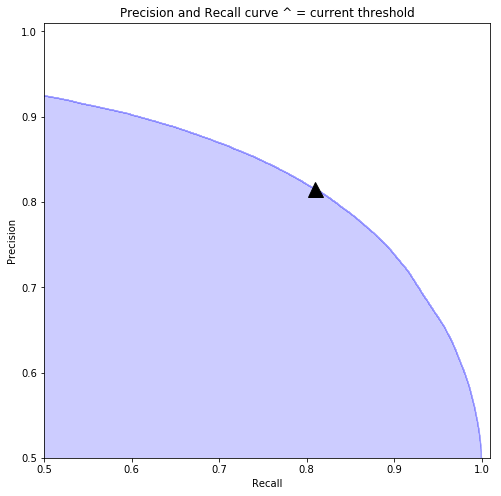

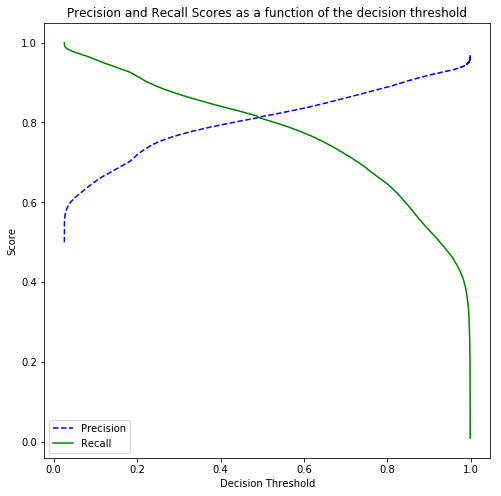

In [65]:
#kerasTokenizer.fit_on_texts(X_train)
t = kerasTokenizer.texts_to_sequences(X_test)
testX = np.array(sequence.pad_sequences(t, maxlen=20, padding='post'))
prediction = model.predict(testX, batch_size=None, verbose=0, steps=None)

precision, recall, thresholds = precision_recall_curve(y_test, prediction)
precision_recall_threshold(precision, recall, thresholds, 0.5)
plot_precision_recall_vs_threshold(precision, recall, thresholds)

In [67]:
y_pred_adj = adjusted_classes(prediction, 0.48) 
accuracy = accuracy_score(y_test, y_pred_adj)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_adj, average='binary')
 
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", f1_score)

('Accuracy: ', 0.81346875)
('Precision: ', 0.8100162871492534)
('Recall: ', 0.8184605565324039)
('F1 score: ', 0.8142165284728965)


## LSTM

In [76]:
from keras import regularizers
RNNmodel = Sequential()
RNNmodel.add(Embedding(400000, 32, input_length=20))
RNNmodel.add(LSTM(128, dropout_U=0.2, dropout_W=0.2, return_sequences=True))
RNNmodel.add(LSTM(256, return_sequences=False))

RNNmodel.add(Dense(1,activation='sigmoid'))
RNNmodel.summary()

RNNmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1])

/Users/troyxiao/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
  after removing the cwd from sys.path.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 20, 32)            12800000  
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 128)           82432     
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 257       
Total params: 13,276,929
Trainable params: 13,276,929
Non-trainable params: 0
_________________________________________________________________


In [77]:
checkpoint = ModelCheckpoint(filepath='./RNN_model.hdf5', verbose=1, save_best_only=True)

history = RNNmodel.fit(X, y_train, 
                    batch_size=128, 
                    verbose=1, 
                    validation_split=0.2, 
                    epochs=5, 
                    callbacks = [checkpoint])

Train on 1024000 samples, validate on 256000 samples
Epoch 1/5
1024000/1024000 [==============================] - 3097s 3ms/step - loss: 0.4349 - acc: 0.7982 - f1: 0.7955 - val_loss: 0.4047 - val_acc: 0.8138 - val_f1: 0.8059

Epoch 00001: val_loss improved from inf to 0.40470, saving model to ./RNN_model.hdf5
Epoch 2/5
1024000/1024000 [==============================] - 3207s 3ms/step - loss: 0.3770 - acc: 0.8307 - f1: 0.8285 - val_loss: 0.3939 - val_acc: 0.8207 - val_f1: 0.8185

Epoch 00002: val_loss improved from 0.40470 to 0.39388, saving model to ./RNN_model.hdf5
Epoch 3/5
1024000/1024000 [==============================] - 3053s 3ms/step - loss: 0.3463 - acc: 0.8471 - f1: 0.8452 - val_loss: 0.4003 - val_acc: 0.8196 - val_f1: 0.8143

Epoch 00003: val_loss did not improve from 0.39388
Epoch 4/5
1024000/1024000 [==============================] - 2850s 3ms/step - loss: 0.3216 - acc: 0.8598 - f1: 0.8582 - val_loss: 0.4082 - val_acc: 0.8171 - val_f1: 0.8182

Epoch 00004: val_loss did not 

     pred_neg  pred_pos
neg    129431     30758
pos     28355    131456


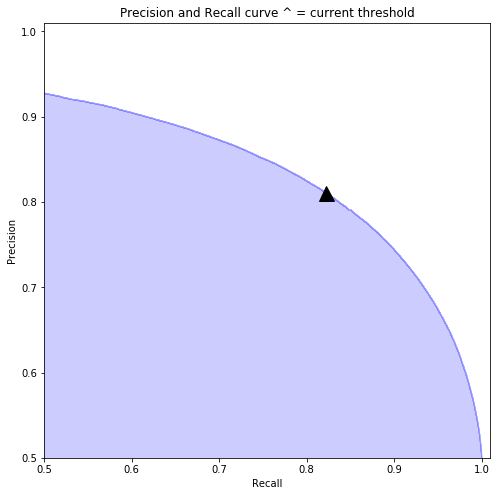

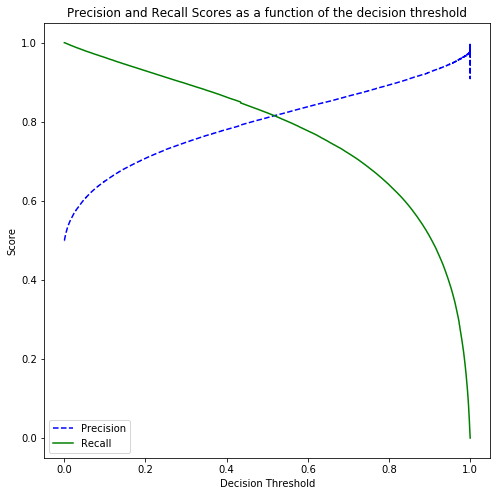

In [78]:
t = kerasTokenizer.texts_to_sequences(X_test)
testX = np.array(sequence.pad_sequences(t, maxlen=20, padding='post'))
prediction = RNNmodel.predict(testX, batch_size=None, verbose=0, steps=None)

precision, recall, thresholds = precision_recall_curve(y_test, prediction)
precision_recall_threshold(precision, recall, thresholds, 0.5)
plot_precision_recall_vs_threshold(precision, recall, thresholds)

In [81]:
y_pred_adj = adjusted_classes(prediction, 0.5) 
accuracy = accuracy_score(y_test, y_pred_adj)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_adj, average='binary')
 
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", f1_score)

('Accuracy: ', 0.815271875)
('Precision: ', 0.8103862798525405)
('Recall: ', 0.8225716627766549)
('F1 score: ', 0.8164335067153171)


## Word2Vec + Keras
#### Following code are partially adapted from a post with some modification: https://ahmedbesbes.com/sentiment-analysis-on-twitter-using-word2vec-and-keras.html

In [26]:
lemmatizer = WordNetLemmatizer() 
tokenized_tweets =[]

for tweet in tweets:  
    tokens = tokenizer.tokenize(tweet)
    x = [lemmatizer.lemmatize(token) for token in tokens] 
    tokenized_tweets.append(x)
    
X_train_TL, X_test_TL, y_train_TL, y_test_TL = train_test_split(tokenized_tweets, sentiment, test_size = 0.20, random_state=123)

In [27]:
LabeledSentence = gensim.models.doc2vec.LabeledSentence 

def labelizeTweets(tweets, label_type):
    labelized = []
    for count,value in tqdm(enumerate(tweets)):
        label = '%s_%s'%(label_type, count)
        labelized.append(LabeledSentence(value, [label]))
    return labelized

x_train = labelizeTweets(X_train_TL, 'TRAIN')
x_test = labelizeTweets(X_test_TL, 'TEST')

0it [00:00, ?it/s]/Users/troyxiao/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  import sys
1280000it [00:15, 81915.70it/s] 
320000it [00:02, 110512.65it/s]


In [28]:
n_dim = 200

tweet_w2v = Word2Vec(size=n_dim, min_count=10)
tweet_w2v.build_vocab([x.words for x in tqdm(x_train)])
tweet_w2v.train([x.words for x in tqdm(x_train)],total_examples=tweet_w2v.corpus_count, epochs=tweet_w2v.iter)

100%|██████████| 1280000/1280000 [00:01<00:00, 849920.66it/s]
/Users/troyxiao/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """


(70490305, 97628055)

In [29]:
print 'building tf-idf matrix ...'
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
matrix = vectorizer.fit_transform([x.words for x in x_train])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
print 'vocab size :', len(tfidf)

building tf-idf matrix ...
vocab size : 36502


In [30]:
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += tweet_w2v[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [31]:
train_vecs_w2v = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x: x.words, x_train))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x: x.words, x_test))])
test_vecs_w2v = scale(test_vecs_w2v)

  0%|          | 0/1280000 [00:00<?, ?it/s]/Users/troyxiao/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
100%|██████████| 320000/320000 [03:23<00:00, 1574.09it/s]


In [43]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=n_dim))
#model.add(Dropout(0.2))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy', f1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 32)                6432      
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 9         
Total params: 6,705
Trainable params: 6,705
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.fit(train_vecs_w2v, y_train_TL, epochs=20, batch_size=128, verbose=1)

Epoch 1/20
1280000/1280000 [==============================] - 23s 18us/step - loss: 0.4602 - acc: 0.7805 - f1: 0.7778
Epoch 2/20
1280000/1280000 [==============================] - 18s 14us/step - loss: 0.4452 - acc: 0.7899 - f1: 0.7873
Epoch 3/20
1280000/1280000 [==============================] - 19s 15us/step - loss: 0.4410 - acc: 0.7922 - f1: 0.7897
Epoch 4/20
1280000/1280000 [==============================] - 19s 15us/step - loss: 0.4387 - acc: 0.7937 - f1: 0.7912
Epoch 5/20
1280000/1280000 [==============================] - 19s 15us/step - loss: 0.4370 - acc: 0.7947 - f1: 0.7925
Epoch 6/20
1280000/1280000 [==============================] - 19s 15us/step - loss: 0.4357 - acc: 0.7955 - f1: 0.7931
Epoch 7/20
1280000/1280000 [==============================] - 19s 15us/step - loss: 0.4347 - acc: 0.7960 - f1: 0.7936
Epoch 8/20
1280000/1280000 [==============================] - 19s 15us/step - loss: 0.4340 - acc: 0.7964 - f1: 0.7940
Epoch 9/20
1280000/1280000 [============================

     pred_neg  pred_pos
neg     83418     76651
pos     83239     76692


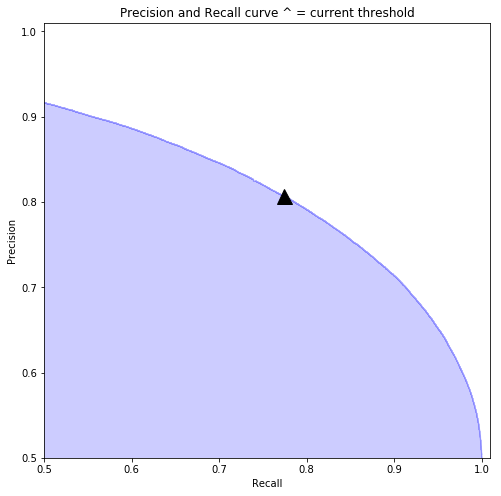

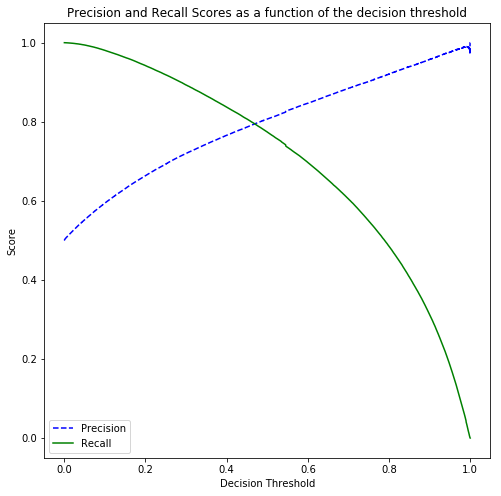

In [45]:
prediction=model.predict(test_vecs_w2v, batch_size=None, verbose=0, steps=None)

precision, recall, thresholds = precision_recall_curve(y_test_TL, prediction)
precision_recall_threshold(precision, recall, thresholds, 0.5)
plot_precision_recall_vs_threshold(precision, recall, thresholds)

In [53]:
y_pred_adj = adjusted_classes(prediction, 0.46) 
accuracy = accuracy_score(y_test_TL, y_pred_adj)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_TL, y_pred_adj, average='binary')
 
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", f1_score)

('Accuracy: ', 0.79453125)
('Precision: ', 0.7907326027702064)
('Recall: ', 0.8004592465603434)
('F1 score: ', 0.7955661961320815)


## CNN+LSTM

In [6]:
kerasTokenizer = Tokenizer(num_words=400000)
kerasTokenizer.fit_on_texts(X_train)
t = kerasTokenizer.texts_to_sequences(X_train)
X = np.array(sequence.pad_sequences(t, maxlen=20, padding='post'))

print(X.shape, y_train.shape)

((1280000, 20), (1280000,))


In [9]:
model = Sequential()
model.add(Embedding(400000, 32, input_length=20))

model.add(Conv1D(filters=128, kernel_size=6, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=64, kernel_size=7, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=32, kernel_size=8, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(LSTM(128, dropout_U=0.2, dropout_W=0.2, return_sequences=True))
model.add(LSTM(256, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(5,activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1])

/Users/troyxiao/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
  app.launch_new_instance()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 32)            12800000  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 20, 128)           24704     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 10, 128)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 10, 64)            57408     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 5, 64)             0         
__________

In [12]:
checkpoint = ModelCheckpoint(filepath='./test_CNN+LSTM_model.hdf5', verbose=1, save_best_only=True)

history = model.fit(X, y_train, 
                    batch_size=128, 
                    verbose=1, 
                    validation_split=0.2, 
                    epochs=4, 
                    callbacks = [checkpoint])

Train on 1024000 samples, validate on 256000 samples
Epoch 1/4
1024000/1024000 [==============================] - 2034s 2ms/step - loss: 0.4471 - acc: 0.8001 - f1: 0.7931 - val_loss: 0.3958 - val_acc: 0.8214 - val_f1: 0.8218

Epoch 00001: val_loss improved from inf to 0.39580, saving model to ./test_CNN+LSTM_model.hdf5
Epoch 2/4
1024000/1024000 [==============================] - 2030s 2ms/step - loss: 0.3809 - acc: 0.8370 - f1: 0.8318 - val_loss: 0.3925 - val_acc: 0.8224 - val_f1: 0.8158

Epoch 00002: val_loss improved from 0.39580 to 0.39250, saving model to ./test_CNN+LSTM_model.hdf5
Epoch 3/4
1024000/1024000 [==============================] - 2161s 2ms/step - loss: 0.3394 - acc: 0.8595 - f1: 0.8554 - val_loss: 0.3987 - val_acc: 0.8201 - val_f1: 0.8178

Epoch 00003: val_loss did not improve from 0.39250
Epoch 4/4
1024000/1024000 [==============================] - 1865s 2ms/step - loss: 0.3054 - acc: 0.8760 - f1: 0.8726 - val_loss: 0.4269 - val_acc: 0.8160 - val_f1: 0.8127

Epoch 0000

     pred_neg  pred_pos
neg    132894     27556
pos     31593    127957


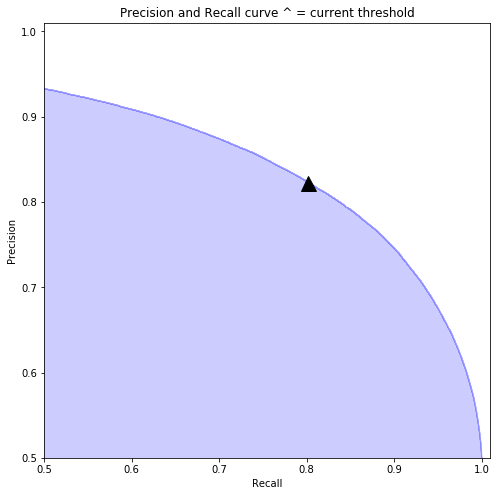

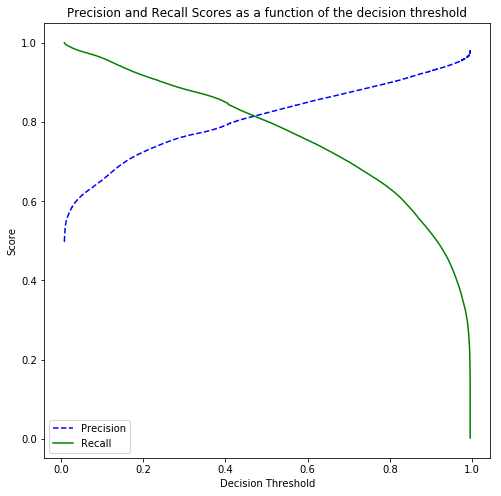

In [15]:
#kerasTokenizer.fit_on_texts(X_train)
t = kerasTokenizer.texts_to_sequences(X_test)
testX = np.array(sequence.pad_sequences(t, maxlen=20, padding='post'))
prediction = model.predict(testX, batch_size=None, verbose=0, steps=None)

precision, recall, thresholds = precision_recall_curve(y_test, prediction)
precision_recall_threshold(precision, recall, thresholds, 0.5)
plot_precision_recall_vs_threshold(precision, recall, thresholds)

In [17]:
y_pred_adj = adjusted_classes(prediction, 0.44) 
accuracy = accuracy_score(y_test, y_pred_adj)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_adj, average='binary')
 
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", f1_score)

('Accuracy: ', 0.815209375)
('Precision: ', 0.8064726815482185)
('Recall: ', 0.8280915073644626)
('F1 score: ', 0.8171391286331433)
